In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

<h2> Activation function for all nodes uses the following sigmoid function </h2>
<h1> $$ \frac{1}{(1 + e^{-\theta^\intercal X})} $$ </h1>

In [2]:
def sigmoid(layer_input):
    return 1 / (1 + np.exp(-(layer_input)))

In [3]:
def add_ones_row(layer_output):
    if (layer_output.ndim == 1):
        layer_output = layer_output.reshape(1,len(layer_output)) # single dimension will lead to error
    ones = np.ones((1,layer_output.shape[1]), dtype = float) # adding in 1s for bias weight
    layer_output = np.append(ones, layer_output, axis=0)
    return layer_output

In [4]:
def forward_propagation(weights, X):
    n = len(weights) # number of layers - 1, also number of iterations for foward propagation
    layer_outputs = []
    layer_output = X.transpose() # makes a copy as we need to add 1 to it to form first layer output
    for i in range(n):
        layer_output = add_ones_row(layer_output) # adding column of 1 so bias term for each layer is included
        layer_outputs.append(layer_output) # important to include the 1 in as it is used for calculation in back propagation
        layer_weight = weights[i]
        layer_input = np.matmul(layer_weight, layer_output) # calculating z, input to next layer
        layer_output = sigmoid(layer_input) # calculating z, output of next layer
    layer_outputs.append(layer_output)
    return layer_outputs

In [5]:
def calculate_cost(final_output, weights, y, lbd):
    m = final_output.shape[1]
    sum_squared_weights = sum(list(map(lambda x: (x**2).sum(),weights))) # sum of squared weights
    regularization_cost = (lbd/(2*m))*(sum_squared_weights)
    cost = (1/m)*(-y*np.log(final_output)-(1-y)*np.log(1-final_output)).sum() + regularization_cost
    return cost

In [6]:
def back_propagation(weights, layer_outputs, y):
    n = len(weights) # number of layers - 1, also number of iterations for foward propagation
    gradients = []
    layer_error = None;
    for i in range(n,0,-1): # from n to 1 inclusive
        if (i == n):
            layer_error = layer_outputs[i] - y # final layer output - y
        else:    
            layer_error = np.matmul(weights[i].transpose(),layer_error)*layer_outputs[i]*(1-layer_outputs[i]) # vectorized implementation for layer error calculation
            layer_error =  np.delete(layer_error, (0), axis=0) # remove first row which correspond to bias node
        if (layer_error.ndim == 1):
            layer_error = layer_error.reshape(1,len(layer_error)) # reshape from 1d to 2d so no error occurs
        grad = np.matmul(layer_error,layer_outputs[i-1].transpose())
        gradients.insert(0,grad)
    return gradients
        

In [7]:
def neural_network(X, y, network_structure, iterations, alpha, lbd):
    weights=[]
    train_costs = []
    m = X.shape[0]
    for i in range(len(network_structure)-1): # intializing weights
        layer_weights = np.random.rand(network_structure[i+1],network_structure[i]+1) # +1 for bias
        if (layer_weights.ndim == 1):
            layer_weights = layer_weights.reshape(1,len(layer_weights))
        weights.append(layer_weights)
    print(weights)    
    for i in range(iterations):
        layer_outputs = forward_propagation(weights, X) # forward propagation to calculate output of nodes at each layer
        iter_cost = calculate_cost(layer_outputs[-1], weights, y, lbd)
        train_costs.append(iter_cost)
        gradients = back_propagation(weights, layer_outputs, y) # back progagation to calculate gradient of nodes at each layer
        for j in range(len(weights)):
            weights[j] -= (alpha/m)*(gradients[j]) + (lbd/m)*(weights[j])    
    x_graph = np.arange(0,iterations,1);    
    plt.plot(x_graph,train_costs, label='train') 
    plt.legend()
    return weights

In [8]:
def normalize(X, mean, std):
    return (X-mean) / std

In [9]:
def prediction(X, weights, threshold):
    layer_outputs = forward_propagation(weights, X)
    pred_result = layer_outputs[-1]
    print(pred_result)
    pred_result = (pred_result>=threshold).astype(int) # those above threshold = 1, 0 otherwise
    return pred_result

In [10]:
def gradient_checking(X, y, network_structure, lbd):
    grads_test = []
    epsilon = 0.0001
    weights = []
    m=X.shape[0]
    
    for i in range(len(network_structure)-1): # intializing weights
        layer_weights = np.random.rand(network_structure[i+1],network_structure[i]+1) # +1 for bias
        if (layer_weights.ndim == 1):
            layer_weights = layer_weights.reshape(1,len(layer_weights))
        weights.append(layer_weights)
        
    for layer_weight in weights:
        rows = layer_weight.shape[0]
        cols = layer_weight.shape[1]
        grad = np.zeros((rows ,cols))
        for j in range(rows):
            for k in range(cols):
                layer_weight[j][k] += epsilon
                layer_output_1 = forward_propagation(weights, X)

                cost_1 = calculate_cost(layer_output_1[-1], weights, y, lbd)
                layer_weight[j][k] -= 2*epsilon
                layer_output_2 = forward_propagation(weights, X)
                cost_2 = calculate_cost(layer_output_2[-1], weights, y, lbd)
                layer_weight[j][k] += epsilon
                
                grad[j][k] = (cost_1 - cost_2) / (2*epsilon)
        grads_test.append(grad)
        
    layer_outputs = forward_propagation(weights, X) # forward propagation to calculate output of nodes at each layer
    iter_cost = calculate_cost(layer_outputs[-1], weights, y, lbd)
    grads_train = back_propagation(weights, layer_outputs, y) # back progagation to calculate gradient of nodes at each layer
    
    total_diff = 0
    num_weights = 0
    
    for i in range(len(weights)):
        grads_train[i] = (1/m)*(grads_train[i]) + (lbd/m)*(weights[i]) # calculating gradient with partial derivative found from back propagation
        diff = np.abs(grads_train[i] - grads_test[i]).sum() # finding sum of absolute difference between test and train gradients 
        total_diff += diff
        num_weights += grads_train[i].shape[0] * grads_train[i].shape[1]
        
    print(grads_train)
    print(grads_test)
    print(total_diff / num_weights) # calculate average difference of gradience per weight (should be very small, scale of x10^(-9))
    

In [11]:
df = pd.read_csv("data/mobile_price_classification_train.csv")
train_x = df.loc[:, df.columns != "price_range"]
train_y = df["price_range"]
train_mean = train_x.mean(axis=0) # mean normalization
train_std = train_x.std(axis=0)
train_x = normalize(train_x,train_mean ,train_std).values
train_y = train_y.values
n_values = np.max(train_y) + 1
train_y = np.eye(n_values)[train_y]
train_y = train_y[:,0]
train_y = train_y.reshape(1,len(train_y))
gradient_checking(train_x, train_y , [train_x.shape[1],2,2,1], 0.1)

[array([[ 5.65468382e-03,  4.28318566e-04, -1.82259580e-04,
        -7.34934013e-04, -3.90940304e-04, -4.85274922e-04,
        -5.13759921e-04, -4.22346978e-04, -2.54148424e-04,
        -4.82947930e-04, -1.69004821e-04, -5.29537360e-04,
         2.59901662e-04,  9.80098092e-05,  3.45765943e-03,
        -8.14903825e-04, -5.46882055e-04,  4.66970571e-05,
        -1.29366659e-04, -6.46243731e-04, -7.05214969e-04],
       [ 6.84253486e-04,  5.86850652e-05,  1.24709022e-05,
        -5.82962645e-05,  1.62550282e-05, -9.71487758e-05,
        -2.52585856e-05, -5.46863881e-06,  1.61453494e-05,
        -1.12836858e-05, -2.92683867e-05, -6.91764663e-05,
         7.46641219e-05,  7.54188437e-05,  4.10939309e-04,
        -5.50568085e-05, -1.33377481e-05,  2.39770535e-05,
        -1.98274579e-05, -3.68638602e-05, -2.13642302e-05]]), array([[0.07969347, 0.05025539, 0.04690903],
       [0.00264894, 0.00168324, 0.00154389]]), array([[0.50117808, 0.37535348, 0.37086407]])]
[array([[ 5.65468382e-03,  4.2

In [31]:
df = pd.read_csv("data/logistic_diabetes.csv")
print(df.isnull().sum())
print(len(df[df['Outcome']==1]))
print(len(df[df['Outcome']==0])) # making sure data is balanced, a bit of imbalance but should be okay
# train=df.sample(frac=0.75,random_state=150) #random state is a seed value
# test=df.drop(train.index)

train = df.iloc[1:400]
display(train)

train_x = train.loc[:,train.columns != "Outcome"] # splitting dependent and independent variables
# test_x = test.loc[:,test.columns != "Outcome"]
train_y = train['Outcome'].values
# test_y = test['Outcome'].values

train_mean = train_x.mean(axis=0) # mean normalization
train_std = train_x.std(axis=0)
train_x = normalize(train_x,train_mean ,train_std)
# test_x = normalize(test_x,train_mean ,train_std )
train_y = train_y.reshape(1, len(train_y))
print("-----------")
gradient_checking(train_x, train_y, [train_x.shape[1],4,4,1], 0.1)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
268
500


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
395,2,127,58,24,275,27.7,1.600,25,0
396,3,96,56,34,115,24.7,0.944,39,0
397,0,131,66,40,0,34.3,0.196,22,1
398,3,82,70,0,0,21.1,0.389,25,0


-----------
[array([[ 6.68621997e-03, -2.20711711e-03, -3.07110927e-03,
        -1.92486190e-05, -2.43181658e-04, -1.00861303e-03,
        -2.12590705e-03, -1.39568933e-03, -2.33016861e-03],
       [ 5.20857224e-03, -1.31520043e-03, -2.48488261e-03,
        -2.72897847e-05,  6.37420339e-05, -7.88165623e-04,
        -1.51618695e-03, -1.00710198e-03, -1.53217665e-03],
       [ 9.10543760e-03, -1.51260778e-03, -2.90363467e-03,
        -5.67272720e-04, -1.76326654e-04, -5.72963310e-04,
        -2.04020403e-03, -8.70016993e-04, -1.65116558e-03],
       [ 9.46921040e-03, -2.70747411e-03, -4.64762696e-03,
        -2.99647788e-04, -8.46793358e-04, -1.74202313e-03,
        -2.86335892e-03, -2.10128241e-03, -3.05342620e-03]]), array([[0.0235151 , 0.00995316, 0.00892951, 0.00686734, 0.0101593 ],
       [0.03079621, 0.01336519, 0.01205655, 0.00904789, 0.01344367],
       [0.0084828 , 0.00365766, 0.00318381, 0.00243466, 0.00371096],
       [0.06889661, 0.03073997, 0.02781798, 0.02126717, 0.03060281

[array([[0.9193389 , 0.12031966, 0.36599747, 0.7255342 , 0.08879298,
        0.78600672, 0.46351548, 0.32803572, 0.81225905],
       [0.87851572, 0.75093356, 0.44299611, 0.06673896, 0.93124444,
        0.68568681, 0.04163479, 0.84096929, 0.31243777],
       [0.42917611, 0.3646578 , 0.33883979, 0.7309456 , 0.88599319,
        0.85770175, 0.39675614, 0.044755  , 0.60511416],
       [0.51162246, 0.21402573, 0.46369248, 0.40923053, 0.22248187,
        0.67050578, 0.07166797, 0.73178682, 0.33663167],
       [0.91289838, 0.8807377 , 0.52464718, 0.19940547, 0.02562506,
        0.20316966, 0.26278723, 0.39764437, 0.22112962]]), array([[0.86676766, 0.97942881, 0.2072498 , 0.82980405, 0.08733432,
        0.14481994]])]


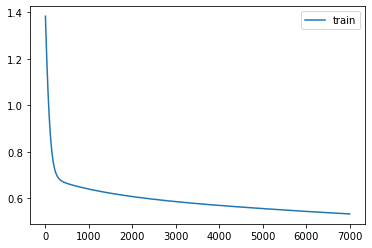

In [32]:
weights = neural_network(train_x, train_y, [train_x.shape[1],5,1], 7000, 0.01, 0)

In [33]:
pred_y = prediction(train_x, weights, 0.5)
result = (pred_y == train_y).astype(int)
print(result.sum() / result.shape[1])

[[0.13874023 0.55421553 0.13750157 0.63545221 0.20000379 0.14243966
  0.28247473 0.63997326 0.16527893 0.32407597 0.66660405 0.62522877
  0.64006852 0.62451025 0.23339707 0.56976239 0.24145755 0.30440227
  0.34831249 0.56528129 0.52604294 0.68882059 0.2958151  0.64055595
  0.53474089 0.64855589 0.1336441  0.61886424 0.43536893 0.6037531
  0.59910294 0.14042757 0.13973632 0.52286584 0.3183372  0.5734329
  0.53022177 0.21651379 0.63508527 0.56879905 0.62449521 0.29226675
  0.64297029 0.52179611 0.64295588 0.34867344 0.12772623 0.36571909
  0.14195712 0.12925798 0.1482091  0.14277735 0.64149601 0.63476866
  0.14334388 0.64640753 0.53890506 0.63046091 0.25129698 0.14897591
  0.51100249 0.13833133 0.29423018 0.417154   0.18278014 0.37896581
  0.6241992  0.1324418  0.36362419 0.28132021 0.36877875 0.66413294
  0.44705653 0.14027816 0.14241705 0.21590625 0.24827663 0.32743886
  0.15024811 0.15139669 0.15234262 0.29872488 0.137364   0.67830769
  0.30977385 0.52824277 0.24468528 0.64156853 0.15

[array([[0.56689378, 0.62817265, 0.3762372 , 0.48478741, 0.4578146 ,
        0.62102993, 0.78588317, 0.96693569, 0.09982707, 0.73117261,
        0.86421494, 0.76612939, 0.75466569, 0.41210486, 0.75076499,
        0.84583216, 0.21930499, 0.99315342, 0.98948777, 0.49735296,
        0.87831939],
       [0.79027133, 0.5224789 , 0.01732856, 0.25269697, 0.52428211,
        0.12143927, 0.43024211, 0.86625542, 0.06463252, 0.42488618,
        0.60624995, 0.71683394, 0.7414718 , 0.85857232, 0.53399006,
        0.74844923, 0.0759947 , 0.9383787 , 0.51243212, 0.94389537,
        0.74160982],
       [0.39425114, 0.20175196, 0.68473909, 0.16032303, 0.5652914 ,
        0.33307712, 0.98008925, 0.68347858, 0.91457421, 0.35974243,
        0.19915139, 0.18176236, 0.1478925 , 0.92962724, 0.95070958,
        0.29468731, 0.2591577 , 0.53002942, 0.60288081, 0.18438587,
        0.50723503],
       [0.29445857, 0.63997632, 0.52516202, 0.70273575, 0.40076788,
        0.91031285, 0.40136606, 0.96646913, 0.835758

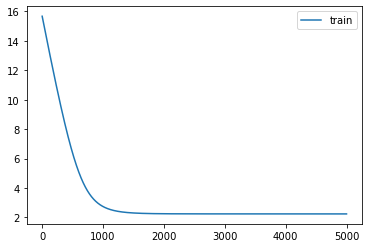

In [34]:
df = pd.read_csv("data/mobile_price_classification_train.csv")
train_x = df.loc[:, df.columns != "price_range"]
train_y = df["price_range"]
train_mean = train_x.mean(axis=0) # mean normalization
train_std = train_x.std(axis=0)
train_x = normalize(train_x,train_mean ,train_std).values
train_y = train_y.values
n_values = np.max(train_y) + 1
train_y = np.eye(n_values)[train_y]
# gradient_checking(train_x, train_y, [train_x.shape[1],2,2,1], 0.1)
weights = neural_network(train_x, train_y.transpose(), [train_x.shape[1],10,10,train_y.shape[1]], 5000, 0.001, 0)

In [35]:
pred_y = prediction(train_x, weights, 0.5)

[[0.32957432 0.21385579 0.21421535 ... 0.22019154 0.21963959 0.21307949]
 [0.30354343 0.2326025  0.23301406 ... 0.23812238 0.23737402 0.23175485]
 [0.26245389 0.24839944 0.24847844 ... 0.25070976 0.25303947 0.24799321]
 [0.3130183  0.25049399 0.25054511 ... 0.25237928 0.2504618  0.25043406]]


In [73]:
np.random.seed(5)
X=np.random.normal(size=(500,4)) * 10
beta1 = np.random.normal(size=(4,)) * 2
beta2 = np.random.normal(size=(4,)) * 3
y = X @ (beta1 ** 2) + X @ beta2 + np.random.normal(size=(500,))
print(y)
y = (y > 0).astype(int)
train_x = X[:400, :]
train_y = y[:400]
test_x = X[:400, :]
test_y = y[:400]
print("---X---")
print(X)
print("---beta---")
print(beta)
print("---y---")
print(y)

[ 456.00484405   41.69414893 -296.76259797 -264.85673196  -20.12656321
 -320.90377055  123.95702882  144.6472803   -24.83174037  196.23993966
  -50.32355832  435.5283476   276.18055562 -222.52748868  470.60632769
   82.58270861  252.48534744 -286.10226999 -303.32572074 -147.28351107
  233.51048781   16.59756636  120.05805374 -220.1151115    30.63007995
 -327.04026667    3.14327136  103.12217146 -531.07793418   28.99652563
   12.09163352 -224.00305067  -64.05863138   82.6354104   293.6778142
  476.29314172   95.23801196   94.11638787  116.33829871 -249.23765197
  121.76199341  -43.84048693  -70.80988984  174.85710571 -108.18645448
 -118.19945214   60.04083634  -34.48822927 -147.96754431  160.59694715
 -308.70112075  200.148303     83.27682528   -3.82995516   66.83508563
 -156.89843686  -90.19367443    7.21068951  116.92523008 -190.78489104
    4.30143118 -469.85459011   34.42009584  398.75178174    6.46966836
  106.80831669  234.76173371  177.51136586  190.18291207  141.18511973
 -296.9

[array([[0.47354236, 0.32733302, 0.76215499, 0.84269386, 0.1212724 ],
       [0.35235551, 0.51444852, 0.03779016, 0.3721308 , 0.83963233],
       [0.62835116, 0.10670393, 0.46250696, 0.66336644, 0.53577632],
       [0.17113427, 0.46609931, 0.96290914, 0.67226535, 0.88164363]]), array([[0.76741982, 0.54822342, 0.60900636, 0.63032623, 0.51965283]])]


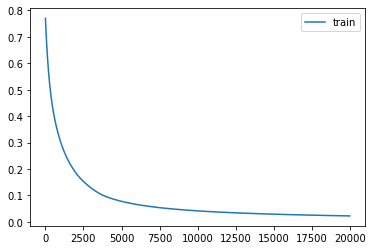

In [58]:
weights = neural_network(train_x, train_y, [train_x.shape[1],4,1], 20000, 0.01, 0)

In [76]:
pred_y = prediction(test_x, weights, 0.5)
print("---")
pred_y = pred_y.ravel()
result = (pred_y == test_y).astype(int)
print(result.sum() / len(result))

[[0.99336706 0.99482681 0.01979782 0.02052246 0.05591755 0.0205223
  0.9935372  0.99604255 0.04301922 0.99335389 0.0151601  0.99335496
  0.99349947 0.01303823 0.9939611  0.99606432 0.9933709  0.02050975
  0.02018868 0.01279198 0.99335389 0.966315   0.9960962  0.01212339
  0.98882201 0.01210929 0.88803965 0.99609552 0.02052187 0.99044009
  0.94328941 0.02052261 0.02144628 0.99331262 0.99335389 0.99335748
  0.99609112 0.99363564 0.99538589 0.01210284 0.99498062 0.01888435
  0.02093723 0.99335398 0.02035308 0.01224886 0.99585343 0.02272988
  0.01210345 0.9933554  0.02052256 0.99337445 0.99606507 0.48657689
  0.99597151 0.01210315 0.02052047 0.88186202 0.99579013 0.02052263
  0.8123168  0.0205136  0.99023433 0.9933539  0.89509809 0.99501735
  0.99335439 0.99337418 0.99610325 0.99533544 0.01210293 0.96322191
  0.02276539 0.99602198 0.99283988 0.99335532 0.99610326 0.99609908
  0.99352641 0.01212415 0.01291108 0.99580898 0.99602935 0.99376048
  0.02052125 0.01918164 0.01212648 0.36924475 0.0

In [ ]:
weights